# Oral Cancer Detection Prototype

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from PIL import Image

## Load and Preprocess Image Data

Images are loaded from directories labeled 'CANCER' (class 1) and 'NON CANCER' (class 0). Each image is resized to 128×128 pixels for uniformity, as neural networks require fixed input dimensions. Resizing reduces computational cost while preserving essential features. The choice of 128×128 balances detail retention and memory efficiency, common in image classification tasks. Images are stored as NumPy arrays for efficient processing.

In [9]:
data_dir = 'data'
categories = ['CANCER', 'NON CANCER']
images = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = 1 if category == 'CANCER' else 0
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with shape {images.shape}")
print(f"Labels distribution: {np.bincount(labels)}")

libpng warning: iCCP: extra compressed data


Loaded 950 images with shape (950, 128, 128, 3)
Labels distribution: [450 500]


## Standardization Techniques

Pixel values are normalized to [0,1] by dividing by 255, scaling raw intensities to a common range. This accelerates convergence in gradient-based optimization by preventing large gradients. Mean subtraction centers the data around zero by subtracting per-channel means, reducing bias and improving training stability. For traditional ML, z-score normalization (subtract mean, divide by std) could be applied, but mean subtraction suffices here. Mathematically, for an image $I$, normalized $I' = I / 255$, standardized $I'' = I' - \mu$ where $\mu$ is the mean across dataset.

In [10]:
# Normalize pixel values to [0, 1]
images_normalized = images.astype('float32') / 255.0

# Mean subtraction (per channel)
mean = np.mean(images_normalized, axis=(0,1,2))
images_standardized = images_normalized - mean

# Z-score normalization (optional, but for traditional ML)
# scaler = StandardScaler()
# images_flat = images_normalized.reshape(images_normalized.shape[0], -1)
# images_zscore = scaler.fit_transform(images_flat)

print(f"Normalized images shape: {images_normalized.shape}")
print(f"Standardized images shape: {images_standardized.shape}")
print(f"Mean values: {mean}")

Normalized images shape: (950, 128, 128, 3)
Standardized images shape: (950, 128, 128, 3)
Mean values: [0.4259227  0.4422846  0.64462095]


## Feature Extraction

Images are flattened into 1D vectors for traditional ML models like SVM, transforming 128×128×3 = 49,152 features. For CNNs, 3D tensors are used directly. Data is split 80/20 into train/test sets with stratification (random_state=42 for reproducibility). This evaluates generalization to unseen data, preventing overfitting. The split ratio balances training data availability and reliable evaluation.

In [11]:
# Flatten images for traditional ML models
images_flat = images_standardized.reshape(images_standardized.shape[0], -1)

# For CNN, use the standardized images directly
# Split data
X_train_flat, X_test_flat, y_train, y_test = train_test_split(images_flat, labels, test_size=0.2, random_state=42)
X_train_cnn, X_test_cnn, _, _ = train_test_split(images_standardized, labels, test_size=0.2, random_state=42)

print(f"Flattened features shape: {images_flat.shape}")
print(f"Train set size: {X_train_flat.shape[0]}, Test set size: {X_test_flat.shape[0]}")

Flattened features shape: (950, 49152)
Train set size: 760, Test set size: 190


## Train and Evaluate SVM Model

SVM finds the hyperplane maximizing margin between classes. For non-linear data, RBF kernel maps to higher dimensions. Evaluation uses precision, recall, F1-score for imbalanced classes.

In [12]:
# Train SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_flat, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_flat)

# Evaluate
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        93
           1       0.79      0.89      0.83        97

    accuracy                           0.82       190
   macro avg       0.83      0.82      0.82       190
weighted avg       0.83      0.82      0.82       190

SVM Accuracy: 0.8211


## Train and Evaluate CNN Model

CNNs learn hierarchical features via convolution. 

Conv2D applies filters (kernels) to extract edges/textures; 32 filters of 3×3 size capture local patterns. MaxPooling (2×2) reduces spatial dimensions, retaining max values for invariance. 

ReLU activation $f(x) = \max(0, x)$ introduces non-linearity. Second conv layer (64 filters) learns complex features. 

Flatten converts to 1D, Dense layers classify. Dropout (0.5) randomly deactivates neurons to prevent overfitting. 

Sigmoid output for binary classification. 

Binary cross-entropy loss $L = -\frac{1}{N} \sum (y \log \hat{y} + (1-y) \log (1-\hat{y}))$ with Adam optimizer for efficient training.

In [13]:
# Build CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Evaluate
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int).flatten()
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

/home/pedro/code/diagnose/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 490ms/step - accuracy: 0.5970 - loss: 0.7387 - val_accuracy: 0.7237 - val_loss: 0.6215
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.7434 - loss: 0.5544 - val_accuracy: 0.7763 - val_loss: 0.5002
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.8125 - loss: 0.4228 - val_accuracy: 0.7500 - val_loss: 0.5333
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.8635 - loss: 0.3496 - val_accuracy: 0.8092 - val_loss: 0.4150
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 497ms/step - accuracy: 0.9046 - loss: 0.2480 - val_accuracy: 0.7961 - val_loss: 0.4336
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 493ms/step - accuracy: 0.9145 - loss: 0.2101 - val_accuracy: 0.8224 - val_loss: 0.4050
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.9572 - loss: 0.1271 - val_accuracy: 0.8421 - val_loss: 0.4301
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.9770 - loss: 0.0835 - val_accuracy: 0

## Compare Model Performances

Accuracy measures correct predictions over total. 

Precision $P = \frac{TP}{TP+FP}$ is true positives over predicted positives; 

recall $R = \frac{TP}{TP+FN}$ is true positives over actual positives. 

F1-score $F1 = 2 \frac{P \cdot R}{P + R}$ balances precision and recall. 

Bar plot compares accuracies visually. Training history plot shows overfitting if validation accuracy plateaus while training increases. These metrics evaluate trade-offs in binary classification for medical diagnosis.

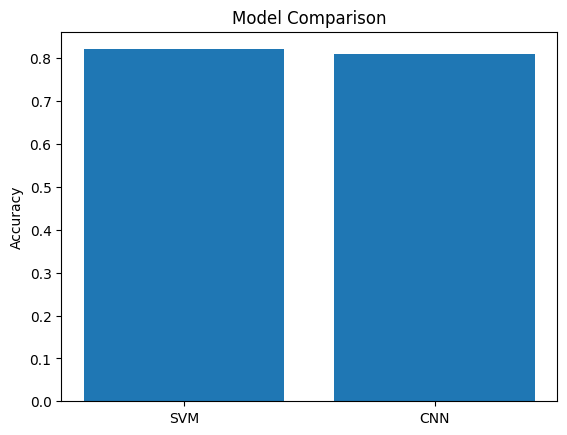

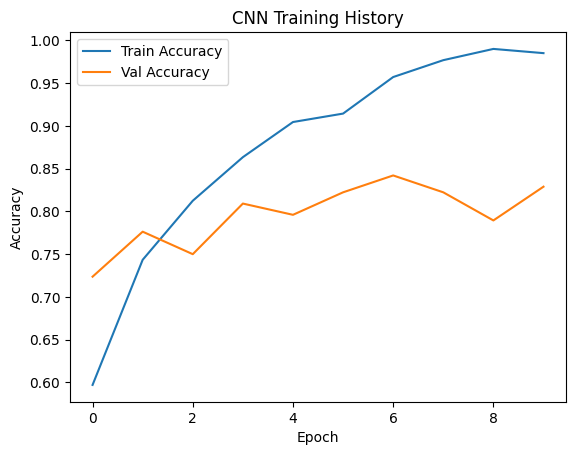

In [14]:
# Compare accuracies
svm_acc = accuracy_score(y_test, y_pred_svm)
cnn_acc = accuracy

models = ['SVM', 'CNN']
accuracies = [svm_acc, cnn_acc]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()

# Plot CNN training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN Training History')
plt.show()